<a href="https://colab.research.google.com/github/konan-91/OcularClassification/blob/master/notebooks/1_data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Generating Topoplots from Blinks

Our first step is to transform the dataset of ocular & non-ocular EEG data into spectograms (image files) that we can use to train the model.

In [6]:
!pip install mne -q
!pip install pymatreader -q

In [7]:
import mne
import pymatreader
import os

##Loading the data

Note: if you are running this notebook yourself, please ensure the zipped osf dataset is present at the root of your working directory. In Colab, this is /content.

In [3]:
!unzip -q /content/osfstorage-archive.zip
!rm /content/osfstorage-archive.zip

In [4]:
def load_data(folderpath, data):
    for filename in os.listdir(folderpath):
        if filename.endswith(".set"):
            filepath = os.path.join(folderpath, filename)
            epochs = mne.read_epochs_eeglab(filepath) # The dataset we use comes pre-epoched
            data.append(epochs)

In [ ]:
#mne.set_log_level('ERROR')
path = "/content/osfstorage-archive"
participants_data = []

for study in os.listdir(path):
    study_path = os.path.join(path, study)
    if os.path.isdir(study_path):
        load_data(study_path, participants_data)

<Info | 8 non-empty values
 bads: []
 ch_names: FPz, FCz, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, ...
 chs: 80 EEG, 3 EOG
 custom_ref_applied: False
 dig: 83 items (3 Cardinal, 80 EEG)
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: unspecified
 nchan: 83
 projs: []
 sfreq: 200.0 Hz
>
Type of first participant: <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>
Shape of first participant: (52, 83, 1600)


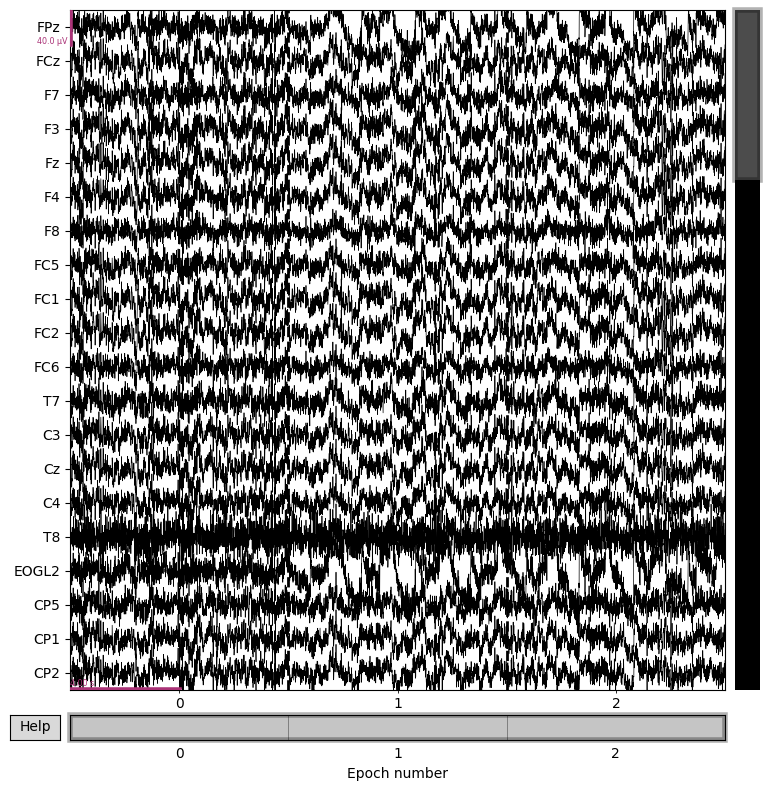

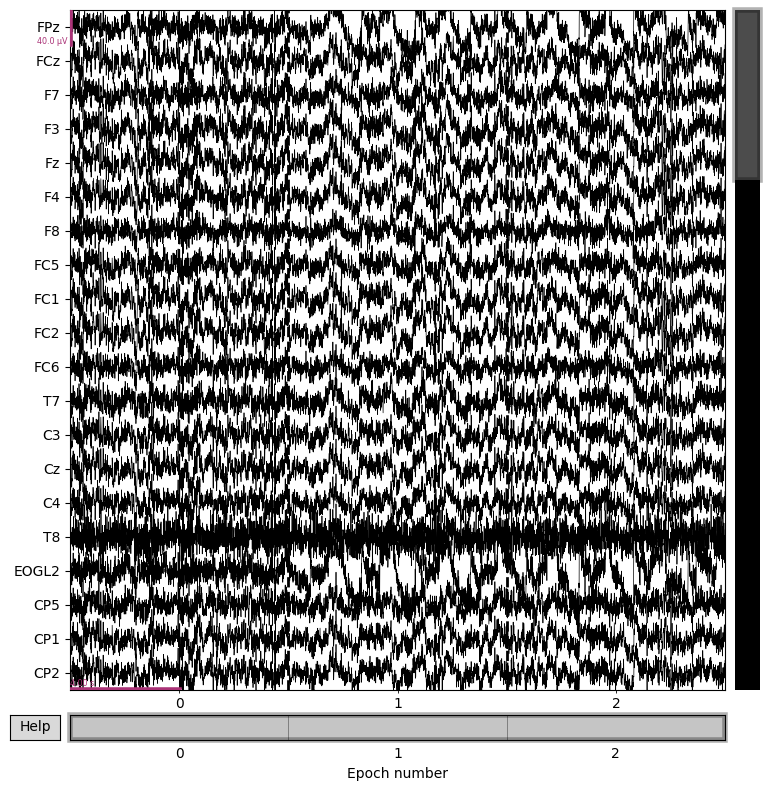

In [40]:
participant_1 = participants_data[0]
print(participant_1.info)

data = participant_1.get_data()
print(f"Type of first participant: {type(participant_1)}")
print(f"Shape of first participant: {data.shape}")

participant_1[0:3].plot()